In [ ]:
from google.colab import drive
drive.mount("E_waste_dataset/")

Drive already mounted at E_waste_dataset/; to attempt to forcibly remount, call drive.mount("E_waste_dataset/", force_remount=True).


In [ ]:
# only if scikit-image missing
!pip install -q scikit-image joblib

import os, glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import random


In [ ]:
# EDIT THIS: point to the dataset folder you extracted or uploaded to Drive
# If you used extraction cell above, dataset is at:
DATA_ROOT = '/content/modified-dataset'   # path that contains 'train' and 'test' subfolders
# If using Drive, an example might be '/content/drive/MyDrive/modified-dataset'

IMG_SIZE = (224,224)       # resize target
MAX_PER_CLASS = None       # set integer like 50 to limit images per class, or None for all
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def gather_from_split(root, split='train', max_per_class=None):
    """
    Expects root/{train,test}/{class_name}/*.jpg
    Returns lists: X_paths, y_labels
    """
    split_dir = os.path.join(root, split)
    classes = sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir,d))])
    X_paths = []
    y = []
    for cls in classes:
        cls_folder = os.path.join(split_dir, cls)
        files = glob.glob(os.path.join(cls_folder, '*'))
        files = sorted(files)
        if max_per_class:
            files = files[:max_per_class]
        X_paths += files
        y += [cls] * len(files)
    return X_paths, y

def load_images_from_paths(paths, img_size=IMG_SIZE):
    X = []
    for p in paths:
        try:
            img = imread(p)
            if img is None:
                print("skipping unreadable:", p); continue
            if img.ndim == 2:                  # grayscale -> convert to 3-channel
                img = np.stack([img]*3, axis=-1)
            # Some images may have alpha channel
            if img.shape[-1] == 4:
                img = img[..., :3]
            img_resized = resize(img, img_size, anti_aliasing=True)
            X.append(img_resized.astype(np.float32))
        except Exception as e:
            print("skip", p, e)
    return np.array(X)


In [ ]:
import os

# Correct dataset path
DATA_ROOT = "/content/ewaste_dataset_extracted/modified-dataset"

# Folders expected: train/, test/, val/
required_folders = ["train", "test"]

for folder in required_folders:
    path = os.path.join(DATA_ROOT, folder)
    if not os.path.isdir(path):
        raise FileNotFoundError(f"Required folder missing: {path}")

print("Dataset structure verified.")

# Gather file paths and labels
train_paths, train_labels = gather_from_split(
    DATA_ROOT,
    split='train',
    max_per_class=MAX_PER_CLASS
)

test_paths, test_labels = gather_from_split(
    DATA_ROOT,
    split='test',
    max_per_class=MAX_PER_CLASS
)

print("Train samples:", len(train_paths))
print("Test samples:", len(test_paths))

# Load images
X_train_imgs = load_images_from_paths(train_paths, IMG_SIZE)
X_test_imgs  = load_images_from_paths(test_paths, IMG_SIZE)

print("Loaded shapes:", X_train_imgs.shape, X_test_imgs.shape)


Dataset structure verified.
Train samples: 2400
Test samples: 300
Loaded shapes: (2400, 224, 224, 3) (300, 224, 224, 3)


In [ ]:
DATA_ROOT = "/content/ewaste_dataset_extracted/modified-dataset"


In [ ]:
# Combine both splits label encoder to ensure consistent classes
le = LabelEncoder()
all_labels = train_labels + test_labels
le.fit(all_labels)

y_train = le.transform(train_labels)
y_test  = le.transform(test_labels)

# Flatten images to 1D feature vectors for RF
n_train = X_train_imgs.shape[0]
n_test  = X_test_imgs.shape[0]
X_train_flat = X_train_imgs.reshape(n_train, -1)
X_test_flat  = X_test_imgs.reshape(n_test, -1)

print("Feature dim:", X_train_flat.shape[1])
print("Classes:", list(le.classes_))


Feature dim: 150528
Classes: [np.str_('Battery'), np.str_('Keyboard'), np.str_('Microwave'), np.str_('Mobile'), np.str_('Mouse'), np.str_('PCB'), np.str_('Player'), np.str_('Printer'), np.str_('Television'), np.str_('Washing Machine')]


In [ ]:
import zipfile
import os

zip_path = "/content/E_waste_dataset/MyDrive/Colab Notebooks/E_waste_dataset /ewaste.zip"
extract_to = "/content/ewaste_dataset_extracted"

# Create folder if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extracted to:", extract_to)
!ls -R /content/ewaste_dataset_extracted


Extracted to: /content/ewaste_dataset_extracted
/content/ewaste_dataset_extracted:
modified-dataset

/content/ewaste_dataset_extracted/modified-dataset:
test  train  val

/content/ewaste_dataset_extracted/modified-dataset/test:
 Battery    Microwave   Mouse   Player	  Television
 Keyboard   Mobile      PCB     Printer  'Washing Machine'

/content/ewaste_dataset_extracted/modified-dataset/test/Battery:
battery_106.jpg  battery_211.jpg  battery_264.jpg  battery_40.jpg
battery_128.jpg  battery_22.jpg   battery_266.jpg  battery_4.jpg
battery_148.jpg  battery_241.jpg  battery_267.jpg  battery_61.jpg
battery_152.jpg  battery_242.jpg  battery_275.jpg  battery_75.jpg
battery_174.jpg  battery_24.jpg   battery_279.jpg  battery_83.jpg
battery_177.jpg  battery_251.jpg  battery_282.jpg  battery_92.jpg
battery_190.jpg  battery_259.jpg  battery_284.jpg
battery_192.jpg  battery_260.jpg  battery_294.jpg

/content/ewaste_dataset_extracted/modified-dataset/test/Keyboard:
Keyboard_106.jpg  Keyboard_211.jp

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
print("Training RandomForest...")
rf.fit(X_train_flat, y_train)
print("Training complete.")


Training RandomForest...
Training complete.


Test accuracy: 0.51
Classification report:
                  precision    recall  f1-score   support

        Battery       0.42      0.57      0.49        30
       Keyboard       0.74      0.57      0.64        30
      Microwave       0.54      0.47      0.50        30
         Mobile       0.37      0.73      0.49        30
          Mouse       0.47      0.23      0.31        30
            PCB       0.52      0.47      0.49        30
         Player       0.71      0.50      0.59        30
        Printer       0.52      0.37      0.43        30
     Television       0.50      0.57      0.53        30
Washing Machine       0.56      0.63      0.59        30

       accuracy                           0.51       300
      macro avg       0.54      0.51      0.51       300
   weighted avg       0.54      0.51      0.51       300



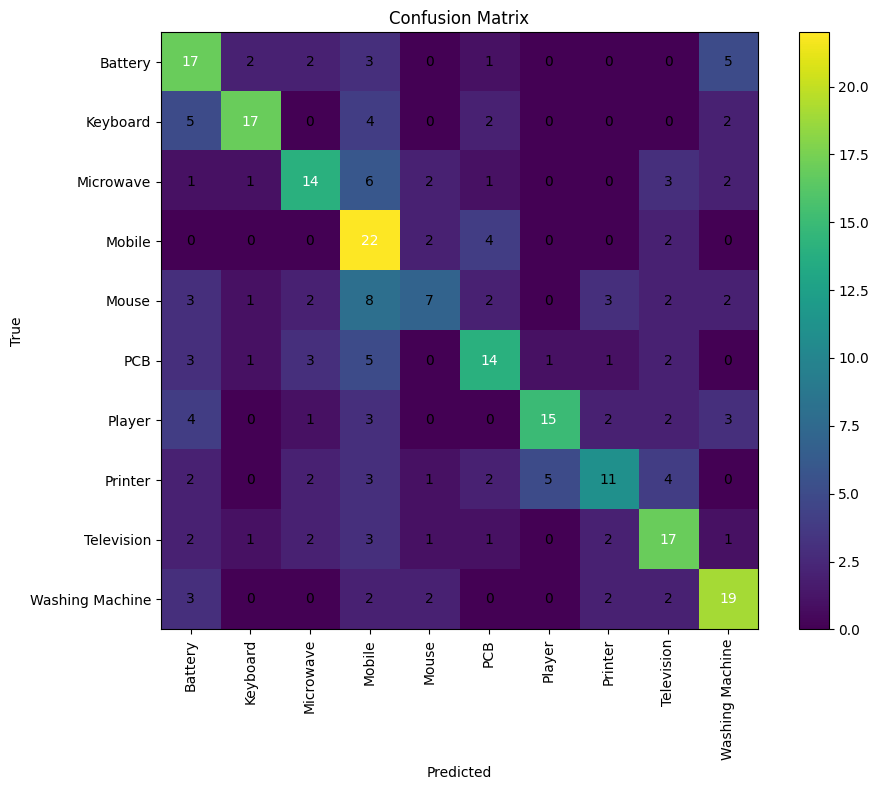

In [ ]:
y_pred = rf.predict(X_test_flat)
acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", acc)
print("Classification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(le.classes_)), le.classes_, rotation=90)
plt.yticks(range(len(le.classes_)), le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# annotate
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


In [ ]:
SAVE_DIR = '/content/drive/MyDrive/E_waste_rf/'  # change to desired path (or '/content/' for local)
os.makedirs(SAVE_DIR, exist_ok=True)
joblib.dump(rf, os.path.join(SAVE_DIR, 'e_waste_rf_model.joblib'))
joblib.dump(le, os.path.join(SAVE_DIR, 'e_waste_label_encoder.joblib'))
print("Saved model and label encoder to", SAVE_DIR)


Saved model and label encoder to /content/drive/MyDrive/E_waste_rf/


File: Keyboard_75.jpg Predicted: PCB


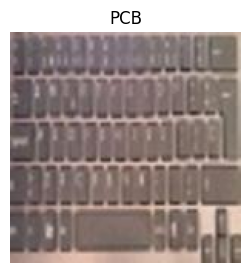

File: battery_242.jpg Predicted: Mobile


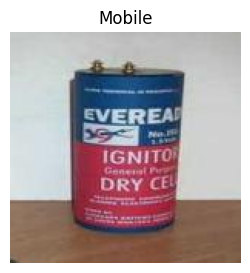

File: Mouse_279.jpg Predicted: Mobile


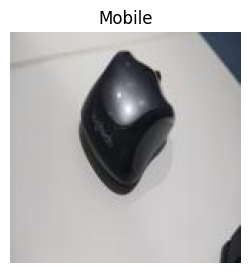

File: Mouse_177.jpg Predicted: Mouse


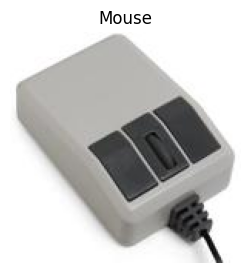

File: Mobile_4.jpg Predicted: Mobile


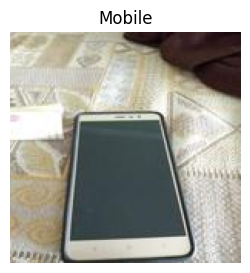

File: Microwave_241.jpg Predicted: Television


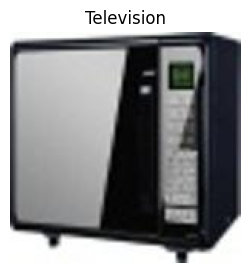

File: Keyboard_284.jpg Predicted: Battery


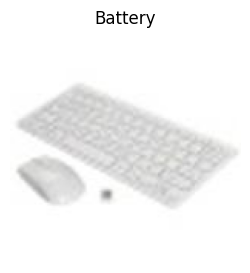

File: Washing_Machine_22.jpg Predicted: Washing Machine


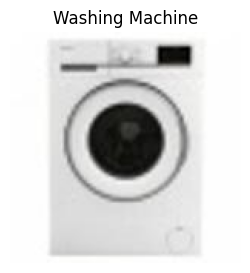

In [ ]:
def predict_from_path(p, model, label_encoder, img_size=IMG_SIZE):
    img = imread(p)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    if img.shape[-1] == 4:
        img = img[..., :3]
    img = resize(img, img_size, anti_aliasing=True).astype(np.float32).reshape(1, -1)
    pred = model.predict(img)[0]
    return label_encoder.inverse_transform([pred])[0]

# show 8 sample predictions from test set
model = rf
for sample_path in random.sample(test_paths, min(8, len(test_paths))):
    pred_label = predict_from_path(sample_path, model, le)
    print("File:", os.path.basename(sample_path), "Predicted:", pred_label)
    img = imread(sample_path)
    plt.figure(figsize=(3,3))
    plt.axis('off')
    if img.ndim==2:
        plt.imshow(img, cmap='gray')
    else:
        if img.shape[-1] == 4:
            img = img[..., :3]
        plt.imshow(img)
    plt.title(pred_label)
    plt.show()


In [ ]:
!ls -R /content/ewaste_dataset_extracted


/content/ewaste_dataset_extracted:
modified-dataset

/content/ewaste_dataset_extracted/modified-dataset:
test  train  val

/content/ewaste_dataset_extracted/modified-dataset/test:
 Battery    Microwave   Mouse   Player	  Television
 Keyboard   Mobile      PCB     Printer  'Washing Machine'

/content/ewaste_dataset_extracted/modified-dataset/test/Battery:
battery_106.jpg  battery_211.jpg  battery_264.jpg  battery_40.jpg
battery_128.jpg  battery_22.jpg   battery_266.jpg  battery_4.jpg
battery_148.jpg  battery_241.jpg  battery_267.jpg  battery_61.jpg
battery_152.jpg  battery_242.jpg  battery_275.jpg  battery_75.jpg
battery_174.jpg  battery_24.jpg   battery_279.jpg  battery_83.jpg
battery_177.jpg  battery_251.jpg  battery_282.jpg  battery_92.jpg
battery_190.jpg  battery_259.jpg  battery_284.jpg
battery_192.jpg  battery_260.jpg  battery_294.jpg

/content/ewaste_dataset_extracted/modified-dataset/test/Keyboard:
Keyboard_106.jpg  Keyboard_211.jpg  Keyboard_264.jpg  Keyboard_40.jpg
Keyboard_12

In [ ]:
DATA_ROOT = "/content/ewaste_dataset_extracted/modified-dataset"


In [ ]:
!mkdir -p src

In [54]:
%%writefile src/my_module.py
    # Content of my_module.py
def greet(name):
        return f"Hello, {name}!"

       class MyClass:
        def __init__(self, value):
            self.value = value

        def get_value(self):
            return self.value

Overwriting src/my_module.py


In [ ]:
import os, glob
from skimage.io import imread
from skimage.transform import resize
import numpy as np

def gather_from_split(root, split='train', max_per_class=None):
    split_dir = os.path.join(root, split)
    classes = sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir,d))])
    X_paths, y = [], []
    for cls in classes:
        cls_folder = os.path.join(split_dir, cls)
        files = glob.glob(os.path.join(cls_folder, '*'))
        files = sorted(files)
        if max_per_class:
            files = files[:max_per_class]
        X_paths += files
        y += [cls] * len(files)
    return X_paths, y

def load_images_from_paths(paths, img_size=(224,224)):
    X = []
    for p in paths:
        try:
            img = imread(p)
            if img is None: continue
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)
            if img.shape[-1] == 4:
                img = img[..., :3]
            img_resized = resize(img, img_size, anti_aliasing=True)
            X.append(img_resized.astype('float32'))
        except Exception as e:
            print('skip', p, e)
    return np.array(X)


In [43]:
    %%writefile src/preprocess.py
    # Content of preprocess.py
    def greet(name):
        return f"Hello, {name}!"

    class MyClass:
        def __init__(self, value):
            self.value = value

        def get_value(self):
            return self.value

Writing src/preprocess.py


In [44]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

def flatten_images(X):
    n = X.shape[0]
    return X.reshape(n, -1)

def encode_labels(y):
    le = LabelEncoder()
    return le.fit_transform(y), le


In [45]:
    %%writefile src/model_rf.py
    # Content of model_rf.py
    def greet(name):
        return f"Hello, {name}!"

    class MyClass:
        def __init__(self, value):
            self.value = value

        def get_value(self):
            return self.value

Writing src/model_rf.py


In [46]:
from sklearn.ensemble import RandomForestClassifier
import joblib

def train_rf(X_train, y_train, n_estimators=200, save_path=None):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    if save_path:
        joblib.dump(rf, save_path)
    return rf


In [47]:
    %%writefile src/evaluate.py
    # Content of evaluate.py
    def greet(name):
        return f"Hello, {name}!"

    class MyClass:
        def __init__(self, value):
            self.value = value

        def get_value(self):
            return self.value

Writing src/evaluate.py


In [48]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    cm = confusion_matrix(y_test, y_pred)
    return acc, report, cm


In [49]:
    %%writefile src/predict.py
    # Content of predict.py
    def greet(name):
        return f"Hello, {name}!"

    class MyClass:
        def __init__(self, value):
            self.value = value

        def get_value(self):
            return self.value

Writing src/predict.py


In [50]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np

def predict_image(filepath, model, label_encoder, img_size=(224,224)):
    img = imread(filepath)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    img = resize(img, img_size).astype('float32').reshape(1, -1)
    pred = model.predict(img)
    return label_encoder.inverse_transform(pred)[0]
